In [1]:
import numpy as np
import random 
from functools import reduce
from scipy.stats import unitary_group
from scipy.sparse import csr_matrix, kron
import matplotlib.pyplot as plt
from IPython.display import display
from PIL import Image


In [2]:
I = np.eye(2)
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])

P0 = np.array([[1, 0], [0, 0]]) # projector onto |0><0|
P1 = np.array([[0, 0], [0, 1]]) # projector onto |1><1|

def kron_all(ops): # suggestion by ChatGPT
    return reduce(np.kron, ops)

def cnot_nqubit(n, control, target):
    ops1 = [I] * n
    ops2 = [I] * n

    ops1[control] = P0
    ops2[control] = P1
    ops2[target] = X

    return kron_all(ops1) + kron_all(ops2)

n = 4

CNOT_01 = cnot_nqubit(n, 0 , 1)
CNOT_12 = cnot_nqubit(n, 1, 2)
CNOT_23 = cnot_nqubit(n, 2, 3)
CNOTS= [CNOT_01, CNOT_12, CNOT_23]



In [3]:
# FUNCTIONS
# defining rotation gates
def Ry(A):
    sn, cs = np.sin(A/2), np.cos(A/2)
    M = np.array([[cs,-sn],[sn, cs]])
    return M
def Rz(A):
    phi = np.exp(-1j*A/2)
    M = np.array([[phi,0],[0,np.conj(phi)]])
    return M
    
#Returns a length-2 array instead of 2x2 matrix; faster, since it's diagonal and good for Z rotations!
def Rz2(A):
    phi = np.exp(-1j*A/2)
    return np.array([phi, np.conj(phi)])
    
def Rz2t(A):
    phi = np.exp(-1j*A/2)
    return np.array([[phi], [np.conj(phi)]])

Z2 = np.array([1,-1])
Z2t = np.array([[1],[-1]])
    
# Parameterising the general unitary with rotation gates
def U(A0,A1,A2): # Arguments: Euler Angles
    M = Rz2t(A1) * Ry(A0) * Rz2(A2)
    return M

#Compute U and all three derivatives together
def DA_all(A0,A1,A2):
    R1 = Rz2t(A1)
    R0 = Ry(A0)
    R2 = Rz2(A2)
    R02 = R0 * R2
    R102 = R1 * R02
    U = R102
    dA0 = (-0.5j) * R1 * (Y @ R02)
    dA1 = (-0.5j) * Z2t * R102
    dA2 = (-0.5j) * R102 * Z2
    return (U, dA0, dA1, dA2)

# defining inverse
def inverse(M):
    M_inverse = M.transpose().conjugate()
    return M_inverse

# generating random initialization
def parameters(layers): 
    A = np.zeros((2*layers,3))
    for i in range(2*layers):
        for j in range(3):
            A[i][j] = random.uniform(0.0, 4*np.pi) 
    return A

#Get the unitary created by these four single-qubit unitaries at layer i.
def U_4squ(A, i):
    U1 = U(A[2*i  ][0],A[2*i  ][1],A[2*i  ][2])
    U2 = U(A[2*i+1][0],A[2*i+1][1],A[2*i+1][2])
    if i%3== 0:
        return np.kron(np.kron(U1, U2), np.eye(4))
    if i%3== 1:
        return np.kron(np.kron(np.kron(np.eye(2), U1),U2),np.eye(2))
    if i%3== 2: 
        return np.kron(np.eye(4),np.kron(U1, U2))
    #return np.kron(np.kron(U1, U2), np.kron(U3, U4))

#Like `U_4squ` - But, optionally, skip the single unitary labelled j.
def U_4squ_skip(A, i, j):
    if i%3==0:
        if j%2==0:
            U1 = np.eye(2)
            U2 =  U(A[2*i+1][0],A[2*i+1][1],A[2*i+1][2])
        else:
            U1 = U(A[2*i  ][0],A[2*i  ][1],A[2*i  ][2])
            U2 = np.eye(2)
        return np.kron(np.kron(U1, U2), np.eye(4))
    if i%3==1:
        if j%2==0:
            U1 = np.eye(2)
            U2 =  U(A[2*i+1][0],A[2*i+1][1],A[2*i+1][2])
        else:
            U1 = U(A[2*i  ][0],A[2*i  ][1],A[2*i  ][2])
            U2 = np.eye(2)
        return np.kron(np.kron(np.kron(np.eye(2), U1),U2),np.eye(2))
    if i%3==2:
        if j%2==0:
            U1 = np.eye(2)
            U2 =  U(A[2*i+1][0],A[2*i+1][1],A[2*i+1][2])
        else:
            U1 = U(A[2*i  ][0],A[2*i  ][1],A[2*i  ][2])
            U2 = np.eye(2)
        return np.kron(np.eye(4),np.kron(U1, U2))
        
#Given a 1-qubit unitary Ui on site s (0-3), expand it to a 4-qubit unitary.
def expand_on_site(Ui, i, j): # i - layer, j - qubit number
    if i%3==0:
        if j%2==0:
            return np.kron(Ui, np.eye(8))
        else:
            return np.kron(np.eye(2), np.kron(Ui, np.eye(4)))
    if i%3==1:
        if j%2==0:
            return np.kron(np.eye(2), np.kron(Ui, np.eye(4)))
        else:
            return np.kron(np.eye(4), np.kron(Ui, np.eye(2)))
    if i%3==2:
        if j%2==0:
            return np.kron(np.eye(4), np.kron(Ui, np.eye(2)))
        else:
           return np.kron(np.eye(8), Ui) 
        

#Like `U_4squ`, but it's only the unitary at the one site j. That is, it's the single-qubit
#unitary, but expanded to 4-qubits.
def U_4squ_only(A, i, j):
    return expand_on_site(U(A[j][0],A[j][1],A[j][2]), i, j)

def circuit_structure(A, layers, j, U_goal): # qubit number    
    q = (j-1) // 2
    Uf = np.eye(16)
    Ub = np.eye(16)
    for it in range(q):
        Uf = Uf @ U_4squ(A, it) @ CNOTS[it%3]
    Uf = Uf @ U_4squ_skip(A, q, j-1)
    for ib in range(q+1, layers):
        Ub = Ub @ CNOTS[(ib-1)%3] @ U_4squ(A, ib)
    U_tbm = inverse(Uf) @ U_goal @ inverse(Ub) # U_tbm = rhs , U to be made
    return U_tbm

#The trace inner product of two matrices. Equal to np.trace(A @ inverse(B)), but faster
def trace_prod_inv(A, B):
    # return np.trace(A @ inverse(B))
    return np.conj(np.vdot(A, B))

In [4]:
#Replaces computing the gradient + gradual adjustment, with just rounding each goal directly to its nearest unitary
#and using that. Note: no "alpha" for learning rate anymore.
def gradient_descent3(layers,U_goal, A, iterations):
    nsu = 2*layers #(number of single qubit unitaries)
    stop_flag=0
    Uerr_array = []

    for i in range(iterations):
        if i%10==0:
            print("iteration",i)
        if stop_flag ==1:
            print("Truncation")
            break

        #Kepp running track of the error: inverse(Uf) * U_goal * inverse(Ub). We'll update this dynamically.
        Ub = U_4squ(A, 0)
        for l in range(1, layers):
            Ub = Ub @ CNOTS[(l-1)%3] @ U_4squ(A, l)
        Ui_err = U_goal @ inverse(Ub)
            
        for l in range(0, layers):            
            for s in [0,1]:
                j = 2*l+s
                
                # RHS
                Ui_err = Ui_err @ U_4squ_only(A, l, j)
                
                #Compute the partial trace of Ui, to leave just the `s` qubit part
                if l%3== 0:
                    if j%2==0:
                        Ui2 = np.trace(Ui_err.reshape(2,8, 2,8), axis1=1, axis2=3)
                    else:
                        Ui2 = Ui_err.reshape(2,2,4, 2,2,4)
                        Ui2 = np.trace(Ui2, axis1=0, axis2=3)
                        Ui2 = np.trace(Ui2, axis1=1, axis2=3)
                if l%3==1:
                    if j%2==0:
                        Ui2 = Ui_err.reshape(2,2,4, 2,2,4)
                        Ui2 = np.trace(Ui2, axis1=0, axis2=3)
                        Ui2 = np.trace(Ui2, axis1=1, axis2=3)
                    else:
                        Ui2 = Ui_err.reshape(4,2,2, 4,2,2)
                        Ui2 = np.trace(Ui2, axis1=0, axis2=3)
                        Ui2 = np.trace(Ui2, axis1=1, axis2=3)
                if l%3==2:
                    if j%2==0:
                        Ui2 = Ui_err.reshape(4,2,2, 4,2,2)
                        Ui2 = np.trace(Ui2, axis1=0, axis2=3)
                        Ui2 = np.trace(Ui2, axis1=1, axis2=3)
                    else:
                        Ui2 = np.trace(Ui_err.reshape(8,2, 8,2), axis1=0, axis2=2)
                #Round goal to nearest unitary
                svd = np.linalg.svd(Ui2)
                unitized = svd[0] @ svd[2]
                unitized /= np.sqrt(np.linalg.det(unitized)) #Convert from U(2) to SU(2)

                # Get Euler angles
                beta = 2 * np.arctan(np.abs(unitized[1][0] / unitized[0][0]))
                phia = np.angle(unitized[0][0])
                phib = np.angle(unitized[1][0])
                a = phib - phia
                c = -(phia + phib)
                
                A[j][0]=beta
                A[j][1]=a
                A[j][2]=c
                
                #computing cost function
                Uk = unitized
                Tr = trace_prod_inv(Ui2, unitized)
                Abs = np.abs(Tr)
                Uerr = 16 - Abs
                if Uerr < 1e-8:
                    stop_flag=1
                    break
                
                
                Ui_err = inverse(expand_on_site(unitized, l,j)) @ Ui_err
                
            Ui_err = CNOTS[l%3] @ Ui_err @ CNOTS[l%3] # Updating LHS
            if stop_flag==1:
                break
        Uerr_array.append(Uerr)
            
    return Uerr_array

In [16]:
layers = 64
U_goal = (unitary_group.rvs(16))
#print(U_goal)
A = parameters(layers)
Ui = U(0,0,0)
#print(np.shape(A))
AOpt = np.copy(A)
print(np.shape(U_4squ_only(A, layers, 0)))

Uerr = gradient_descent3(layers,U_goal, AOpt, 10000)

(16, 16)
iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100
iteration 110
iteration 120
iteration 130
iteration 140
iteration 150
iteration 160
iteration 170
iteration 180
iteration 190
iteration 200
iteration 210
iteration 220
iteration 230
iteration 240
iteration 250
iteration 260
iteration 270
iteration 280
iteration 290
iteration 300
iteration 310
iteration 320
iteration 330
iteration 340
iteration 350
iteration 360
iteration 370
iteration 380
iteration 390
iteration 400
iteration 410
iteration 420
iteration 430
iteration 440
iteration 450
iteration 460
iteration 470
iteration 480
iteration 490
iteration 500
iteration 510
iteration 520
iteration 530
iteration 540
iteration 550
iteration 560
iteration 570
iteration 580
iteration 590
iteration 600
iteration 610
iteration 620
iteration 630
iteration 640
iteration 650
iteration 660
iteration 670
iteration 680
iteration 690
iteration 700
iteratio

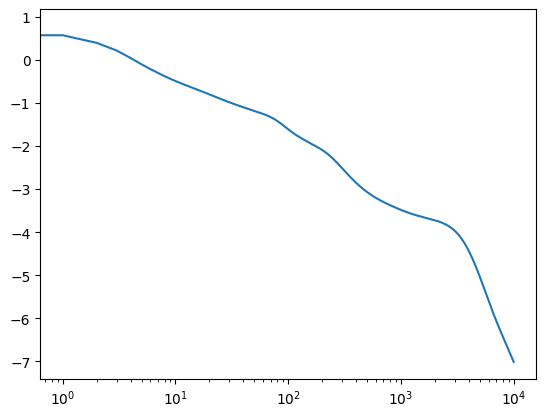

In [17]:
plt.plot(np.log10(Uerr))
plt.xscale('log')

# 5 Different Unitaries - 64 layers

In [22]:
layers = 64
#print(U_goal)
for h in range(5):
    U_goal = (unitary_group.rvs(16))
    A = parameters(layers)
    #print(np.shape(A))
    AOpt =np.copy(A)
    print("Unitary:", h+1)
    Uerr = gradient_descent3(layers,U_goal, AOpt, 30000)
    print("\nIterations:",len(Uerr))
    print("Final error:",np.log10(Uerr[-1]))
    np.save('IBM_0123_5diffunitaries_%d.npy'%(h), Uerr)

Unitary: 1
iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100
iteration 110
iteration 120
iteration 130
iteration 140
iteration 150
iteration 160
iteration 170
iteration 180
iteration 190
iteration 200
iteration 210
iteration 220
iteration 230
iteration 240
iteration 250
iteration 260
iteration 270
iteration 280
iteration 290
iteration 300
iteration 310
iteration 320
iteration 330
iteration 340
iteration 350
iteration 360
iteration 370
iteration 380
iteration 390
iteration 400
iteration 410
iteration 420
iteration 430
iteration 440
iteration 450
iteration 460
iteration 470
iteration 480
iteration 490
iteration 500
iteration 510
iteration 520
iteration 530
iteration 540
iteration 550
iteration 560
iteration 570
iteration 580
iteration 590
iteration 600
iteration 610
iteration 620
iteration 630
iteration 640
iteration 650
iteration 660
iteration 670
iteration 680
iteration 690
iteration 700
iterat

In [6]:
load1 = np.load('IBM_0123_5diffunitaries_0.npy')
load2 = np.load('IBM_0123_5diffunitaries_1.npy')
load3 = np.load('IBM_0123_5diffunitaries_2.npy')
load4 = np.load('IBM_0123_5diffunitaries_3.npy')
load5 = np.load('IBM_0123_5diffunitaries_4.npy')

plt.plot(load1, label='Unitary-1')
plt.plot(load2, label='Unitary-2')
plt.plot(load3, label='Unitary-3')
plt.plot(load4, label='Unitary-4')
plt.plot(load5, label='Unitary-5')
plt.yscale('log')
plt.ylim(1e-8,1e2)
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('C($ \Theta, \phi, \lambda$)')
plt.savefig('IBM 0123 different unitaries')
plt.close()

# Same Unitary 5 initialisations - 64 layers

In [35]:
layers = 64
U_goal = (unitary_group.rvs(16))
#print(U_goal)
for h in range(1):
    A = parameters(layers)
    #print(np.shape(A))
    AOpt =np.copy(A)
    print("Initialisation:", h+1)
    Uerr = gradient_descent3(layers,U_goal, AOpt, 30000)
    print("\nIterations:",len(Uerr))
    print("Final error:",np.log10(Uerr[-1]))
    np.save('IBM_0123_5diffinitial_3.npy', Uerr)

Initialisation: 1
iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100
iteration 110
iteration 120
iteration 130
iteration 140
iteration 150
iteration 160
iteration 170
iteration 180
iteration 190
iteration 200
iteration 210
iteration 220
iteration 230
iteration 240
iteration 250
iteration 260
iteration 270
iteration 280
iteration 290
iteration 300
iteration 310
iteration 320
iteration 330
iteration 340
iteration 350
iteration 360
iteration 370
iteration 380
iteration 390
iteration 400
iteration 410
iteration 420
iteration 430
iteration 440
iteration 450
iteration 460
iteration 470
iteration 480
iteration 490
iteration 500
iteration 510
iteration 520
iteration 530
iteration 540
iteration 550
iteration 560
iteration 570
iteration 580
iteration 590
iteration 600
iteration 610
iteration 620
iteration 630
iteration 640
iteration 650
iteration 660
iteration 670
iteration 680
iteration 690
iteration 700

In [8]:
load1 = np.load('IBM_0123_5diffinitial_0.npy')
load2 = np.load('IBM_0123_5diffinitial_1.npy')
load3 = np.load('IBM_0123_5diffinitial_2.npy')
load4 = np.load('IBM_0123_5diffinitial_3.npy')
load5 = np.load('IBM_0123_5diffinitial_4.npy')


plt.plot(load1, label='Initialization-1')
plt.plot(load2, label='Initialization-2')
plt.plot(load3, label='Initialization-3')
plt.plot(load4, label='Initialization-4')
plt.plot(load5, label='Initialization-5')
plt.yscale('log')
plt.ylim(1e-8,1e2)
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('C($ \Theta, \phi, \lambda$)')
plt.savefig('IBM 0123 different initialization')
plt.close()

# Underparameterised Different Unitaries

In [62]:
layers = 60
#print(U_goal)
for h in range(5):
    U_goal = (unitary_group.rvs(16))
    A = parameters(layers)
    #print(np.shape(A))
    AOpt =np.copy(A)
    print("Initialisation:", h+1)
    Uerr = gradient_descent3(layers,U_goal, AOpt, 20000)
    print("\nIterations:",len(Uerr))
    print("Final error:",np.log10(Uerr[-1]))
    np.save('IBM_0123_60_underparameterised_%d.npy'%(h), Uerr)


Initialisation: 1
iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100
iteration 110
iteration 120
iteration 130
iteration 140
iteration 150
iteration 160
iteration 170
iteration 180
iteration 190
iteration 200
iteration 210
iteration 220
iteration 230
iteration 240
iteration 250
iteration 260
iteration 270
iteration 280
iteration 290
iteration 300
iteration 310
iteration 320
iteration 330
iteration 340
iteration 350
iteration 360
iteration 370
iteration 380
iteration 390
iteration 400
iteration 410
iteration 420
iteration 430
iteration 440
iteration 450
iteration 460
iteration 470
iteration 480
iteration 490
iteration 500
iteration 510
iteration 520
iteration 530
iteration 540
iteration 550
iteration 560
iteration 570
iteration 580
iteration 590
iteration 600
iteration 610
iteration 620
iteration 630
iteration 640
iteration 650
iteration 660
iteration 670
iteration 680
iteration 690
iteration 700

Text(0, 0.5, 'log[C($ \\Theta, \\phi, \\lambda$)]')

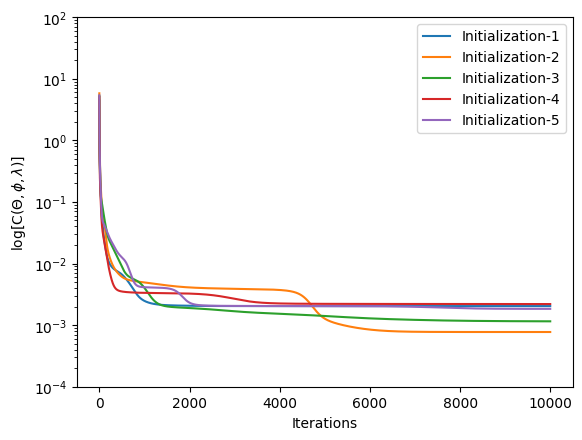

In [14]:
load1 = np.load('IBM_0123_60_underparameterised_0.npy')
load2 = np.load('IBM_0123_60_underparameterised_1.npy')
load3 = np.load('IBM_0123_60_underparameterised_2.npy')
load4 = np.load('IBM_0123_60_underparameterised_3.npy')
load5 = np.load('IBM_0123_60_underparameterised_4.npy')

plt.plot(load1, label='Initialization-1')
plt.plot(load2, label='Initialization-2')
plt.plot(load3, label='Initialization-3')
plt.plot(load4, label='Initialization-4')
plt.plot(load5, label='Initialization-5')
plt.yscale('log')
plt.ylim(1e-4,1e2)
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('log[C($ \Theta, \phi, \lambda$)]')


## Different Layers Same Unitary

In [28]:
U_goal = (unitary_group.rvs(16))
#print(U_goal)
A = parameters(layers)
#print(np.shape(A))
AOpt =np.copy(A)
#print(U_goal)

Uerr = gradient_descent3(30,U_goal, AOpt, 2000)
print("\nIterations:",len(Uerr))
print("Final error:",np.log10(Uerr[-1]))
np.save('IBM_0123_30_diff_layers', Uerr)

Uerr = gradient_descent3(40,U_goal, AOpt, 3000)
print("\nIterations:",len(Uerr))
print("Final error:",np.log10(Uerr[-1]))
np.save('IBM_0123_40_diff_layers', Uerr)

Uerr = gradient_descent3(50,U_goal, AOpt, 5000)
print("\nIterations:",len(Uerr))
print("Final error:",np.log10(Uerr[-1]))
np.save('IBM_0123_50_diff_layers', Uerr)

Uerr = gradient_descent3(60,U_goal, AOpt, 7500)
print("\nIterations:",len(Uerr))
print("Final error:",np.log10(Uerr[-1]))
np.save('IBM_0123_60_diff_layers', Uerr)

Uerr = gradient_descent3(64,U_goal, AOpt, 30000)
print("\nIterations:",len(Uerr))
print("Final error:",np.log10(Uerr[-1]))
np.save('IBM_0123_64_diff_layers', Uerr)

Uerr = gradient_descent3(70,U_goal, AOpt, 30000)
print("\nIterations:",len(Uerr))
print("Final error:",np.log10(Uerr[-1]))
np.save('IBM_0123_70_diff_layers', Uerr)

Uerr = gradient_descent3(80,U_goal, AOpt, 30000)
print("\nIterations:",len(Uerr))
print("Final error:",np.log10(Uerr[-1]))
np.save('IBM_0123_80_diff_layers', Uerr)


iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100
iteration 110
iteration 120
iteration 130
iteration 140
iteration 150
iteration 160
iteration 170
iteration 180
iteration 190
iteration 200
iteration 210
iteration 220
iteration 230
iteration 240
iteration 250
iteration 260
iteration 270
iteration 280
iteration 290
iteration 300
iteration 310
iteration 320
iteration 330
iteration 340
iteration 350
iteration 360
iteration 370
iteration 380
iteration 390
iteration 400
iteration 410
iteration 420
iteration 430
iteration 440
iteration 450
iteration 460
iteration 470
iteration 480
iteration 490
iteration 500
iteration 510
iteration 520
iteration 530
iteration 540
iteration 550
iteration 560
iteration 570
iteration 580
iteration 590
iteration 600
iteration 610
iteration 620
iteration 630
iteration 640
iteration 650
iteration 660
iteration 670
iteration 680
iteration 690
iteration 700
iteration 710
ite

IndexError: index 120 is out of bounds for axis 0 with size 120

In [34]:
layers = 64
U_goal = (unitary_group.rvs(16))
#print(U_goal)
A = parameters(layers)
#print(np.shape(A))
AOpt =np.copy(A)
Uerr = gradient_descent3(layers,U_goal, AOpt, 30000)
print("\nIterations:",len(Uerr))
print("Final error:",np.log10(Uerr[-1]))
np.save('IBM_0123_64_diff_layers', Uerr)


iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100
iteration 110
iteration 120
iteration 130
iteration 140
iteration 150
iteration 160
iteration 170
iteration 180
iteration 190
iteration 200
iteration 210
iteration 220
iteration 230
iteration 240
iteration 250
iteration 260
iteration 270
iteration 280
iteration 290
iteration 300
iteration 310
iteration 320
iteration 330
iteration 340
iteration 350
iteration 360
iteration 370
iteration 380
iteration 390
iteration 400
iteration 410
iteration 420
iteration 430
iteration 440
iteration 450
iteration 460
iteration 470
iteration 480
iteration 490
iteration 500
iteration 510
iteration 520
iteration 530
iteration 540
iteration 550
iteration 560
iteration 570
iteration 580
iteration 590
iteration 600
iteration 610
iteration 620
iteration 630
iteration 640
iteration 650
iteration 660
iteration 670
iteration 680
iteration 690
iteration 700
iteration 710
ite

In [32]:
layers = 70
A = parameters(layers)
#print(np.shape(A))
AOpt =np.copy(A)
Uerr = gradient_descent3(layers,U_goal, AOpt, 30000)
print("\nIterations:",len(Uerr))
print("Final error:",np.log10(Uerr[-1]))
np.save('IBM_0123_70_diff_layers', Uerr)

iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100
iteration 110
iteration 120
iteration 130
iteration 140
iteration 150
iteration 160
iteration 170
iteration 180
iteration 190
iteration 200
iteration 210
iteration 220
iteration 230
iteration 240
iteration 250
iteration 260
iteration 270
iteration 280
iteration 290
iteration 300
iteration 310
iteration 320
iteration 330
iteration 340
iteration 350
iteration 360
iteration 370
iteration 380
iteration 390
iteration 400
iteration 410
iteration 420
iteration 430
iteration 440
iteration 450
iteration 460
iteration 470
iteration 480
iteration 490
iteration 500
iteration 510
iteration 520
iteration 530
iteration 540
iteration 550
iteration 560
iteration 570
iteration 580
iteration 590
iteration 600
iteration 610
iteration 620
iteration 630
iteration 640
iteration 650
iteration 660
iteration 670
iteration 680
iteration 690
iteration 700
iteration 710
ite

In [33]:
layers = 80
A = parameters(layers)
#print(np.shape(A))
AOpt =np.copy(A)
Uerr = gradient_descent3(layers,U_goal, AOpt, 30000)
print("\nIterations:",len(Uerr))
print("Final error:",np.log10(Uerr[-1]))
np.save('IBM_0123_80_diff_layers', Uerr)

iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100
iteration 110
iteration 120
iteration 130
iteration 140
iteration 150
iteration 160
iteration 170
iteration 180
iteration 190
iteration 200
iteration 210
Truncation

Iterations: 213
Final error: -8.00010504989111


In [10]:
load1 = np.load('IBM_0123_30_diff_layers.npy')
load2 = np.load('IBM_0123_40_diff_layers.npy')
load3 = np.load('IBM_0123_50_diff_layers.npy')
load4 = np.load('IBM_0123_60_diff_layers.npy')
load5 = np.load('IBM_0123_64_diff_layers.npy')
load6 = np.load('IBM_0123_70_diff_layers.npy')
load7 = np.load('IBM_0123_80_diff_layers.npy')


plt.plot(load1, label='15 layers')
plt.plot(load2, label='20 layers')
plt.plot(load3, label='30 layers')
plt.plot(load4, label='40 layers')
plt.plot(load5, label='42 layers')
plt.plot(load6, label='50 layers')
plt.plot(load7, label='60 layers')
         
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-8,1e2)
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('C($ \Theta, \phi, \lambda$)')
plt.savefig('IBM Chip 0123 Different layers')
plt.close()